In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_curve, auc
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
import pickle
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Download NLTK data files (if not already installed)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

c:\Users\Rohan\.conda\envs\gpuTraining\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rohan\.conda\envs\gpuTraining\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Rohan\.conda\envs\gpuTraining\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.1 when using version 

Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9968    0.9840    0.9904       313
           1     0.9836    0.9967    0.9901       300

    accuracy                         0.9902       613
   macro avg     0.9902    0.9903    0.9902       613
weighted avg     0.9903    0.9902    0.9902       613

SVM Classification Report:
              precision    recall  f1-score   support

           0     0.9968    0.9904    0.9936       313
           1     0.9901    0.9967    0.9934       300

    accuracy                         0.9935       613
   macro avg     0.9934    0.9935    0.9935       613
weighted avg     0.9935    0.9935    0.9935       613

KNN Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9553    0.9771       313
           1     0.9554    1.0000    0.9772       300

    accuracy                         0.9772       613
   macro avg     0.9777    0.9776    

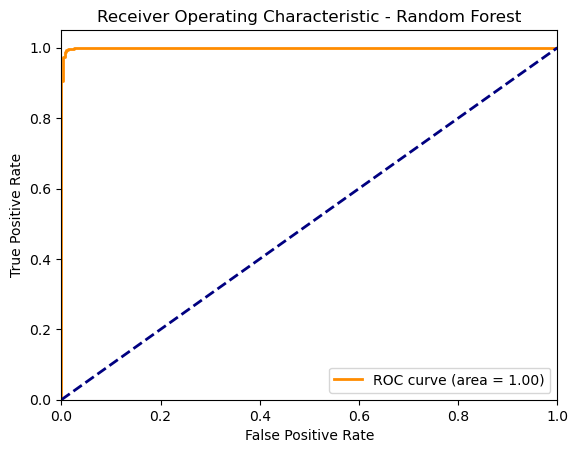

Random Forest AUROC: 0.9995


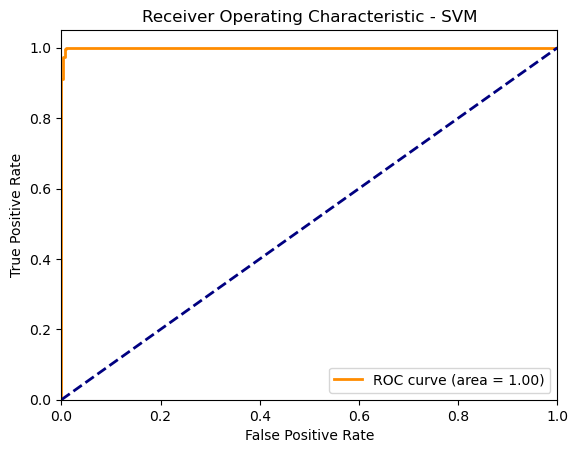

SVM AUROC: 0.9996


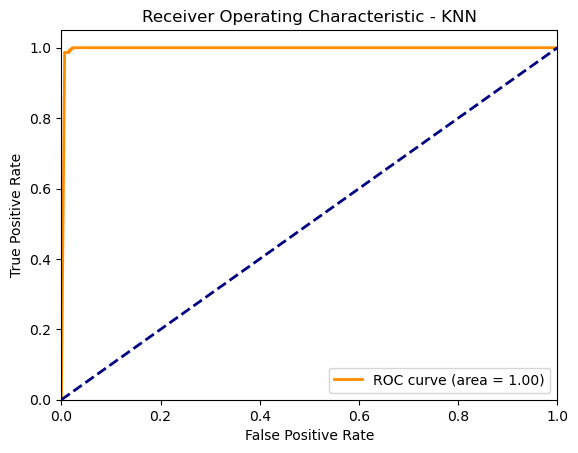

KNN AUROC: 0.9965


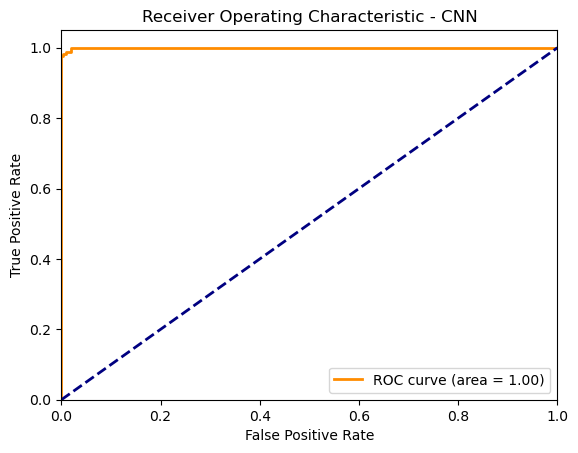

CNN AUROC: 0.9997


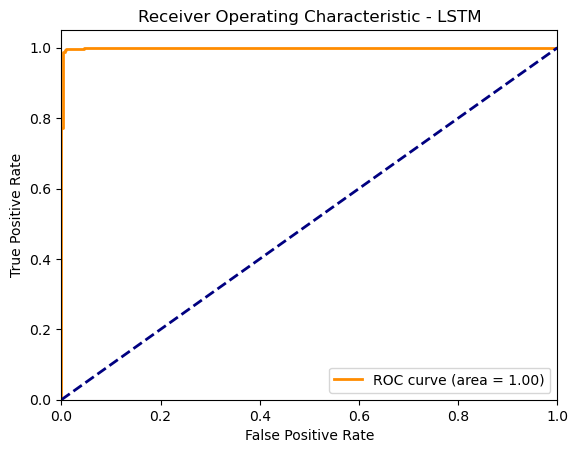

LSTM AUROC: 0.9991


In [5]:

def clean_text(text, stop_words):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'http\S+|www\S+|https\S+', 'URLfound', text, flags=re.MULTILINE)
    text = text.lower()
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

def stem_text(text):
    stemmer = PorterStemmer()
    word_tokens = word_tokenize(text)
    stemmed_text = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stemmed_text)

def ml_preprocess(df):
    stop_words = set(stopwords.words('english'))
    df['subject'].fillna('', inplace=True)
    df['content'] = df['subject'] + ' ' + df['body']
    df['content'] = df['content'].apply(lambda x: clean_text(x, stop_words))
    df['content'] = df['content'].apply(stem_text)
    df = df[['label', 'content']]
    return df

# Load the dataset
df = pd.read_csv("Nazario_5.csv")

# Preprocess the dataset
df = ml_preprocess(df)

# Split the data into training and testing sets
X = df['content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences for deep learning models
max_words = 10000
max_len = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Load traditional ML models
with open('models/rf_pipeline.pkl', 'rb') as f:
    rf_model = pickle.load(f)

with open('models/svm_pipeline.pkl', 'rb') as f:
    svm_model = pickle.load(f)

with open('models/knn_pipeline.pkl', 'rb') as f:
    knn_model = pickle.load(f)

# Load deep learning models
cnn_model = load_model('models/best_cnn_model.h5')
lstm_model = load_model('models/best_lstm_model.h5')


# Predict and print classification report and ROC curve for Random Forest
rf_pred = rf_model.predict(X_test)
rf_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred, digits=4))

# Predict and print classification report and ROC curve for SVM
svm_pred = svm_model.predict(X_test)
svm_pred_prob = svm_model.predict_proba(X_test)[:, 1]
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred, digits=4))

# Predict and print classification report and ROC curve for KNN
knn_pred = knn_model.predict(X_test)
knn_pred_prob = knn_model.predict_proba(X_test)[:, 1]
print("KNN Classification Report:")
print(classification_report(y_test, knn_pred, digits=4))


# Predict and print classification report and ROC curve for CNN
cnn_pred_prob = cnn_model.predict(X_test_pad)
cnn_pred = (cnn_pred_prob > 0.5).astype("int32")
print("CNN Classification Report:")
print(classification_report(y_test, cnn_pred, digits=4))

# Predict and print classification report and ROC curve for LSTM
lstm_pred_prob = lstm_model.predict(X_test_pad)
lstm_pred = (lstm_pred_prob > 0.5).astype("int32")
print("LSTM Classification Report:")
print(classification_report(y_test, lstm_pred, digits=4))

# Plot ROC curves
def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    print(f'{model_name} AUROC: {roc_auc:.4f}')

# Plot ROC curves for all models
plot_roc_curve(y_test, rf_pred_prob, 'Random Forest')
plot_roc_curve(y_test, svm_pred_prob, 'SVM')
plot_roc_curve(y_test, knn_pred_prob, 'KNN')
plot_roc_curve(y_test, cnn_pred_prob, 'CNN')
plot_roc_curve(y_test, lstm_pred_prob, 'LSTM')
